# From poll to indexes

## Setup

In [1]:
from pyspark.sql import SparkSession
import pandas as pd
import os 
import sys 
import json 
from pyspark.ml.clustering import KMeans

os.environ['PYSPARK_DRIVER_PYTHON_OPTS'] = "notebook"
os.environ['PYSPARK_DRIVER_PYTHON'] = sys.executable
os.environ['PYSPARK_PYTHON'] = sys.executable

In [2]:
spark = (
    SparkSession
        .builder
        .appName('poll_to_idxs')
        .getOrCreate()
    )

spark

## CSV loading and cleaning

In [3]:
# the csv poll dir
poll_dir = "../data/poll_data.csv"

# load the csv poll as a dataframe
df = (
    spark.read.format("csv")
    # .option("encoding", "UTF-8")
    .option("header", "true")
    .option("inferSchema", "true")
    .load(poll_dir)
)

# list of columns that will not be considered individually scored
skip_cols = [
    "Ho letto e accettato l'informativa e confermo inoltre di avere più di 18 anni",
    "Informazioni cronologiche",
    "Quanti anni hai?",
    "Genere",
    "Da quante persone è composto il tuo nucleo familiare?",
    "Occupazione",
    "Quanto è grande la tua azienda?",
    "Da che regione provieni?",
    "Provincia di provenienza",
    "In che regione lavori/studi?",
    "Provincia del luogo di lavoro/studio",
    "Invalidità",
    "Tipo di residenza",
    "Numero di persone con cui convivi",
    "Entrate Familiari Mensili Nette",
    "Entrate Personali Mensili Nette ",
]

# load the questions json
with open("../data/questions.json", "r", encoding="utf-8") as questions_file:
    questions = json.load(questions_file)

# create a question_text:question_idx map, useful to alias the columns
questions_idxs = {questions[q]["question_text"]: q for q in questions.keys()}

# alias the columns (long column names cause bugs and are hard to use)
for k, v in questions_idxs.items():
    df = df.withColumnRenamed(k, v)

df.show(5)

+-------------------------+-----------------------------------------------------------------------------+-------------------+---------+-----------------------------------------------------+--------------------+-------------------------------+------------------------+------------------------+----------------------------+------------------------------------+------------------+--------------------+---------------------------------+-------------------------------+--------------------------------+---+---+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+-----------------+----+--------------------+--------------------+--------------------+----+-------------------+--------------------+-------+--------------------+--------------------+---+---+------------------+--------------+---------------+----+--------------+------------+------------+--------------------+------------+----+--------------+-------------+---------------

## Computing the scores

In [4]:
# "subtract" the list of unscorable cols from the list of scorable cols
scorable_cols = [item for item in df.columns if item not in skip_cols]

# iterate over the scorable columns to create the scores dictionary
scores = {}
for col in scorable_cols:
    # shortcuts for some useful values
    question_type = questions[col]["question_type"]
    question_score = questions[col]["question_score"]
    question_answers = questions[col]["answers"]

    # skip unscored questions
    if len(question_answers) == 0 and question_type != "comma_separated":
        continue

    # collect the Row values for the current column and access its value (index 0)
    answers = [str(d[0]) for d in df.select(col).collect()]

    # handle score computation differently based on question_type
    row_scores = []
    if question_type in ["basic", "multivalue"]:
        for a in answers:
            row_scores.append(question_answers[a]["answer_score"] * question_score)

        scores[col] = row_scores

    elif question_type == "comma_separated":
        for i in answers:
            row_scores.append(len(i.split(";")))

        scores[col] = row_scores

In [5]:
# create the scores dataframe from the scores dictionary
df_scores = spark.createDataFrame(pd.DataFrame(scores))
df_scores.show(5)

+----+----+-----+----+----+-----+----+----+-----+----+-----+-----+----+-----+---+---+-----+-----+-----+---+---+-----+-----+----+-----+-----+----+----+----+-----+-----+-----+-----+----+-----+---+---+----+---+---+-----+---+---+----+---+----+----+-----+---+-----+----+----+---+-------+-------+-------+-------+-------+-------+-------+-------+-----+-----+----+
| S_1| S_2|  S_3| S_4| S_5|  S_6| S_7| S_8|  S_9|V_10| V_11| V_12|C_13| C_14|m_1|m_2|  m_3|  m_4|  m_5|m_6|m_7|  m_8|  m_9|m_10| m_11| m_12|m_13|m_14|m_15| m_16| m_17| m_18| m_19|m_20|  eh1|eh2|eh3| eh4|eh5|eh6|  ew1|ew2|ew3| ew4|ew5| ww1| ww2|  ww3|ww4|  wh1| wh2| wh3|wh4|wastew1|wastew2|wastew3|wastew4|wasteh1|wasteh2|wasteh3|wasteh4| ER_1| ER_2|ER_3|
+----+----+-----+----+----+-----+----+----+-----+----+-----+-----+----+-----+---+---+-----+-----+-----+---+---+-----+-----+----+-----+-----+----+----+----+-----+-----+-----+-----+----+-----+---+---+----+---+---+-----+---+---+----+---+----+----+-----+---+-----+----+----+---+-------+------

In [6]:
# the indexes dictionary, which will be used to compute the indexes dataframe
indexes_cols = {}

## Computing the indexes

### Purchases indexes

In [7]:
# Calcolo indici domande relative alla Spesa
df_s = df_scores.select([f"S_{d}" for d in range(1, 10)]).collect()

i_S_col = []
for s in df_s:
    i_S_col.append(sum([val for val in s]) / 1450)
indexes_cols["i_S"] = i_S_col

col_S_1 = df.select("S_1").collect()
S_1 = []
answer1 = questions["S_1"]["answers"]
for i in range(len(col_S_1)):
    s1 = col_S_1[i][0]
    for j in answer1.keys():
        if s1 == j:
            val = answer1[j]["answer_score_1"]
            S_1.append(val)
            break

col_S_2 = df.select("S_2").collect()
S_2 = []
answer2 = questions["S_2"]["answers"]
for i in range(len(col_S_2)):
    s2 = str(col_S_2[i][0])
    for j in answer2.keys():
        if s2 == j:
            val = answer2[j]["answer_score_1"]
            S_2.append(val)
            break
df_s1 = df_scores.select([f"S_{d}" for d in range(3, 10)]).collect()
i_tot_S_col = []
k = 0  # variabile temporanea per accedere agli elementi di S_1 ed S_2 ed effettuare il rapporto
for s_1 in df_s1:
    somma = sum([val1 for val1 in s_1])
    r = S_2[k] / S_1[k]
    i_tot_S_col.append(somma * r)
    k += 1
indexes_cols["i_tot_S"] = i_tot_S_col

In [8]:
# Calcolo indici domande relative al Vestiario
df_v = df_scores.select([f"V_{d}" for d in range(10, 13)]).collect()

i_V_col = []
for v in df_v:
    i_V_col.append(sum([val for val in v]) / 550)

indexes_cols["i_V"] = i_V_col

col_V_10 = df.select("V_10").collect()
V_10 = []
answer10 = questions["V_10"]["answers"]
for i in range(len(col_V_10)):
    v10 = str(col_V_10[i][0])
    for j in answer10.keys():
        if v10 == j:
            val = answer10[j]["answer_score_1"]
            V_10.append(val)
            break
df_v1 = df_scores.select([f"V_{d}" for d in range(11, 13)]).collect()
i_tot_V_col = []
l = 0  # variabile temporanea per accedere agli elementi di V_10
for v1 in df_v1:
    somma1 = sum([val1 for val1 in v1]) / 400
    i_tot_V_col.append(somma1 * V_10[l])
    l += 1
indexes_cols["i_tot_V"] = i_tot_V_col

In [9]:
# Calcolo indici domande relative alla Casa
df_c = df_scores.select([f"C_{d}" for d in range(13, 15)]).collect()

i_C_col = []
for c in df_c:
    i_C_col.append(sum([val for val in c]) / 350)

indexes_cols["i_C"] = i_C_col

i_tot_C_col = []
for c1 in df_c:
    if c1[1] == 0:
        i_tot_C_col.append(c1[0])
    else:
        i_tot_C_col.append(c1[0] / c1[1])
indexes_cols["i_tot_C"] = i_tot_C_col

In [10]:
# Calcolo indice Educazione e Ricerca
df_e = df_scores.select([f"ER_{d}" for d in range(1, 4)]).collect()
i_ER_col = []
for e in df_e:
    i_ER_col.append(sum([val for val in e]) / 500)
indexes_cols["i_ER"] = i_ER_col

### Mobility indexes

In [11]:
df_m1 = df_scores.select(["m_8", "m_9"]).collect()

i_m1_col = []
for s in df_m1:
    m_8, m_9 = s[0], s[1]
    i_m1_col.append(m_9 / m_8)

indexes_cols["i_M1"] = i_m1_col

In [12]:
df_m2 = df_scores.select(["m_17", "m_18"]).collect()

i_m2_col = []
for s in df_m2:
    m_17, m_18 = s[0], s[1]
    i_m2_col.append(m_18 / m_17)

indexes_cols["i_M2"] = i_m2_col

In [13]:
fam_size_col_label = "Da quante persone è composto il tuo nucleo familiare?"

df_m3 = df_scores.select(["m_8"]).collect()
df_fam = df.select([fam_size_col_label]).collect()

i_m3_col = []
for s in df_m3:
    m_8, f = s[0], int(df_fam[0][0])
    i_m3_col.append(m_8 / f)

indexes_cols["i_M3"] = i_m3_col

In [14]:
df_m4 = df_scores.select(["m_11", "m_12", "m_13"]).collect()

i_m4_col = []
for s in df_m4:
    m_11, m_12, m_13 = s[0], s[1], s[2]
    i_m4_col.append(m_12 / m_11 + m_12 + m_13)

indexes_cols["i_M4"] = i_m4_col

In [15]:
df_m5 = df_scores.select(["m_20"]).collect()

i_m5_col = []
for s in df_m5:
    m_20 = s[0]
    i_m5_col.append(m_20)

indexes_cols["i_M5"] = i_m5_col

In [16]:
df_m6 = df_scores.select(["m_19"]).collect()

i_m6_col = []
for s in df_m6:
    m_19 = s[0]
    i_m6_col.append(m_19)

indexes_cols["i_M6"] = i_m6_col

In [17]:
df_m7 = df_scores.select(["m_4", "m_5"]).collect()

i_m7_col = []
for s in df_m7:
    m_4, m_5 = s[0], s[1]
    i_m7_col.append(m_5 / m_4)

indexes_cols["i_M7"] = i_m7_col

### Energy indexes

In [18]:
# Systems (home)
df_e1 = df_scores.select(["eh2"]).collect()
i_e1_col = []
for s in df_e1:
    i_e1_col.append(s[0] / 5)
indexes_cols["i_e1"] = i_e1_col

In [19]:
# Systems (work)
df_e2 = df_scores.select(["ew2"]).collect()
i_e2_col = []
for s in df_e2:
    i_e2_col.append(s[0] / 5)
indexes_cols["i_e2"] = i_e2_col

In [20]:
# Sustainable Source (home)
df_e3 = df_scores.select(["eh3", "eh4"]).collect()
i_e3_col = []
for s in df_e3:
    eh3, eh4 = s[0], s[1]
    i_e3_col.append(eh3 * eh4)
indexes_cols["i_e3"] = i_e3_col

In [21]:
# Sustainable Source (work)
df_e4 = df_scores.select(["ew3", "ew4"]).collect()
i_e4_col = []
for s in df_e4:
    ew3, ew4 = s[0], s[1]
    i_e4_col.append(ew3 * ew4)
indexes_cols["i_e4"] = i_e4_col

In [22]:
# Efficiency Ratio
df_e5 = df_scores.select(["eh1", "eh5"]).collect()
i_e5_col = []
for s in df_e5:
    eh1, eh5 = s[0], s[1]
    i_e5_col.append(eh1 / eh5)
indexes_cols["i_e5"] = i_e5_col

In [23]:
# GreenBuilding (home)
df_e6 = df_scores.select(["eh6"]).collect()
i_e6_col = []
for s in df_e6:
    i_e6_col.append(s[0] / 6)
indexes_cols["i_e6"] = i_e6_col

In [24]:
# GreenBuilding (work)
df_e7 = df_scores.select(["ew5"]).collect()
i_e7_col = []
for s in df_e7:
    i_e7_col.append(s[0] / 6)
indexes_cols["i_e7"] = i_e7_col

### Water Index

In [25]:
# Water (home)
df_water1 = df_scores.select(["wh1", "wh2", "wh3", "wh4"]).collect()
i_e8_col = []
for s in df_water1:
    wh1, wh2, wh3, wh4 = s[0], s[1], s[2], s[3]
    i_e8_col.append((wh1 + wh2 + wh3 + wh4) / 4)
indexes_cols["i_e8"] = i_e8_col

In [26]:
# Water (work)
df_water2 = df_scores.select(["ww1", "ww2", "ww3", "ww4"]).collect()
i_e9_col = []
for s in df_water2:
    ww1, ww2, ww3, ww4 = s[0], s[1], s[2], s[3]
    i_e9_col.append((ww1 + ww2 + ww3 + ww4) / 4)
indexes_cols["i_e9"] = i_e9_col

### Waste Index

In [27]:
# Waste (home)
df_waste1 = df_scores.select(["wasteh1", "wasteh2", "wasteh3", "wasteh4"]).collect()
i_e10_col = []
for s in df_waste1:
    wasteh1, wasteh2, wasteh3, wasteh4 = s[0], s[1], s[2], s[3]
    i_e10_col.append((wasteh1 + wasteh2 + wasteh3 + wasteh4) / 4)
indexes_cols["i_e10"] = i_e10_col

In [28]:
# Waste (work)
df_waste2 = df_scores.select(["wastew1", "wastew2", "wastew3", "wastew4"]).collect()
i_e11_col = []
for s in df_waste1:
    wastew1, wastew2, wastew3, wastew4 = s[0], s[1], s[2], s[3]
    i_e11_col.append((wastew1 + wastew2 + wastew3 + wastew4) / 4)
indexes_cols["i_e11"] = i_e11_col

## Indexes dataframe

In [29]:
# create the indexes dataframe from the indexes dictionary
df_indexes = spark.createDataFrame(pd.DataFrame(indexes_cols))
df_indexes.show()

+-------------------+------------------+-------------------+-------+-------------------+-------+----+------------------+------------------+-----+------------------+----+-----+------------------+----+----+----+----+------------------+-------------------+-------------------+-----+------+-----+-----+
|                i_S|           i_tot_S|                i_V|i_tot_V|                i_C|i_tot_C|i_ER|              i_M1|              i_M2| i_M3|              i_M4|i_M5| i_M6|              i_M7|i_e1|i_e2|i_e3|i_e4|              i_e5|               i_e6|               i_e7| i_e8|  i_e9|i_e10|i_e11|
+-------------------+------------------+-------------------+-------+-------------------+-------+----+------------------+------------------+-----+------------------+----+-----+------------------+----+----+----+----+------------------+-------------------+-------------------+-----+------+-----+-----+
| 0.4286206896551724|             546.5| 0.5227272727272727|   1.25| 0.2842857142857143|   0.99|0.35|1.

In [30]:
from pyspark.ml.linalg import Vectors

df_features = df_indexes.toPandas()

vectors = []
for _, r in df_features.iterrows():
    values = []
    for i in range(len(df_features.columns)):
        values.append(r[i])

    vectors.append(Vectors.dense(values))

vectors

[DenseVector([0.4286, 546.5, 0.5227, 1.25, 0.2843, 0.99, 0.35, 1.3333, 1.0, 18.75, 101.0, 0.0, 0.0, 1.3333, 0.2, 0.2, 0.25, 0.25, 16.6667, 0.1667, 0.1667, 37.5, 56.25, 62.5, 62.5]),
 DenseVector([0.3952, 498.0, 0.3409, 0.75, 0.1429, 0.0, 0.35, 0.6, 0.2, 31.25, 11.0, 50.0, 100.0, 1.0, 0.2, 0.4, 0.0, 1.0, 66.6667, 0.3333, 0.1667, 0.0, 37.5, 200.0, 200.0]),
 DenseVector([0.3693, 996.0, 0.1818, 0.25, 0.2857, 0.0, 0.0, 0.2, 0.3333, 31.25, 10.1, 0.0, 0.0, 0.1, 0.2, 0.2, 0.0, 0.0, 11.1111, 0.1667, 0.1667, 25.0, 0.0, 100.0, 100.0]),
 DenseVector([0.3348, 224.0, 0.1591, 0.25, 0.2857, 0.0, 0.4, 1.6667, 1.0, 18.75, 10.1, 50.0, 0.0, 1.3333, 0.2, 0.2, 0.0, 1.0, 66.6667, 0.3333, 0.1667, 0.0, 0.0, 200.0, 200.0]),
 DenseVector([0.3172, 231.6667, 0.0, 0.0, 0.1429, 0.0, 0.0, 0.4, 1.0, 31.25, 10.0333, 0.0, 25.0, 0.5, 0.2, 0.2, 0.0, 0.0, 66.6667, 0.1667, 0.1667, 0.0, 0.0, 87.5, 87.5]),
 DenseVector([0.3852, 297.3333, 0.0, 0.0, 0.4286, 0.0, 0.0, 0.2, 0.2, 31.25, 10.05, 0.0, 0.0, 1.0, 0.2, 0.2, 0.5, 0.5, 0.

In [31]:
df_vectors = spark.createDataFrame(pd.DataFrame({"features":vectors}))

In [32]:
kmeans = KMeans(k=3)

kmeans.setSeed(1)
# kmeans.setWeightCol("weigh_col")
kmeans.setMaxIter(10)
kmeans.getMaxIter()
kmeans.clear(kmeans.maxIter)
kmeans.getSolver()

model = kmeans.fit(df_vectors)

model.getMaxBlockSizeInMB()
model.getDistanceMeasure()
model.setPredictionCol("prediction")
model.predict(df_vectors.head().features)

centers = model.clusterCenters()
len(centers)

transformed = model.transform(df_vectors).select("features", "prediction")
rows = transformed.collect()

In [33]:
df_features.columns

Index(['i_S', 'i_tot_S', 'i_V', 'i_tot_V', 'i_C', 'i_tot_C', 'i_ER', 'i_M1',
       'i_M2', 'i_M3', 'i_M4', 'i_M5', 'i_M6', 'i_M7', 'i_e1', 'i_e2', 'i_e3',
       'i_e4', 'i_e5', 'i_e6', 'i_e7', 'i_e8', 'i_e9', 'i_e10', 'i_e11'],
      dtype='object')

In [34]:
import seaborn as sns

sns.heatmap(df_features.corr(), cmap="crest")

ModuleNotFoundError: No module named 'seaborn'

In [ ]:
with pd.option_context('display.max_rows', 100, 'display.max_columns', 100):
    display(df_features.corr()[df_features.corr() >= 0.5])

,i_S,i_tot_S,i_V,i_tot_V,i_C,i_tot_C,i_ER,i_M1,i_M2,i_M3,i_M4,i_M5,i_M6,i_M7,i_e1,i_e2,i_e3,i_e4,i_e5,i_e6,i_e7,i_e8,i_e9,i_e10,i_e11
i_S,1.000000,0.534225,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
i_tot_S,0.534225,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
i_V,NaN,NaN,1.000000,0.874201,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
i_tot_V,NaN,NaN,0.874201,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
i_C,NaN,NaN,NaN,NaN,1.000000,0.581929,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
i_tot_C,NaN,NaN,NaN,NaN,0.581929,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
i_ER,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
i_M1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
i_M2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
i_M3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


array([[<AxesSubplot: xlabel='i_S', ylabel='i_S'>,
        <AxesSubplot: xlabel='i_tot_S', ylabel='i_S'>,
        <AxesSubplot: xlabel='i_V', ylabel='i_S'>,
        <AxesSubplot: xlabel='i_tot_V', ylabel='i_S'>,
        <AxesSubplot: xlabel='i_C', ylabel='i_S'>,
        <AxesSubplot: xlabel='i_tot_C', ylabel='i_S'>],
       [<AxesSubplot: xlabel='i_S', ylabel='i_tot_S'>,
        <AxesSubplot: xlabel='i_tot_S', ylabel='i_tot_S'>,
        <AxesSubplot: xlabel='i_V', ylabel='i_tot_S'>,
        <AxesSubplot: xlabel='i_tot_V', ylabel='i_tot_S'>,
        <AxesSubplot: xlabel='i_C', ylabel='i_tot_S'>,
        <AxesSubplot: xlabel='i_tot_C', ylabel='i_tot_S'>],
       [<AxesSubplot: xlabel='i_S', ylabel='i_V'>,
        <AxesSubplot: xlabel='i_tot_S', ylabel='i_V'>,
        <AxesSubplot: xlabel='i_V', ylabel='i_V'>,
        <AxesSubplot: xlabel='i_tot_V', ylabel='i_V'>,
        <AxesSubplot: xlabel='i_C', ylabel='i_V'>,
        <AxesSubplot: xlabel='i_tot_C', ylabel='i_V'>],
       [<AxesSubplo

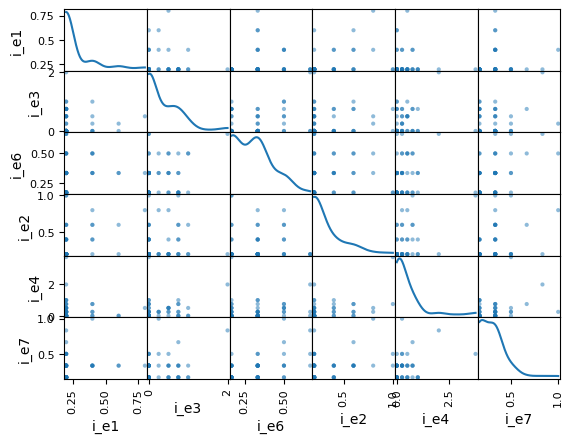

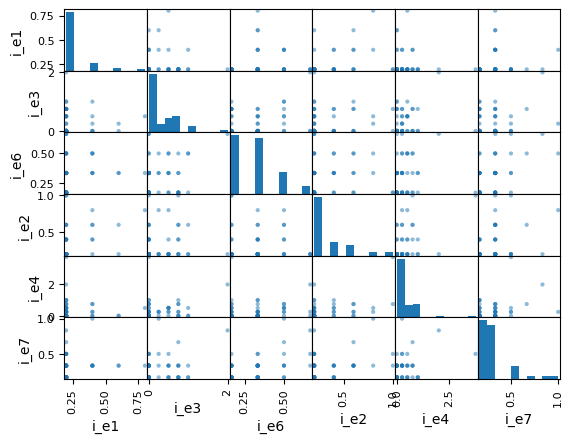

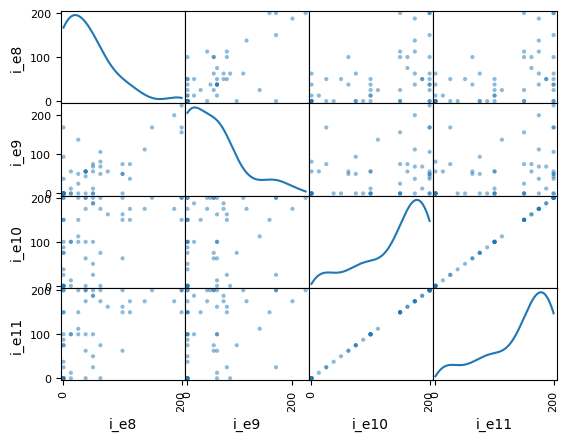

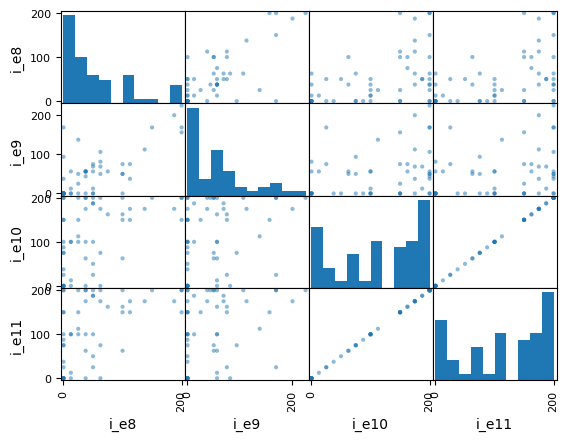

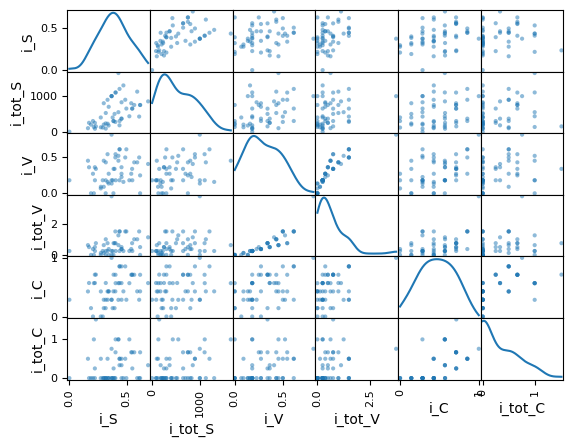

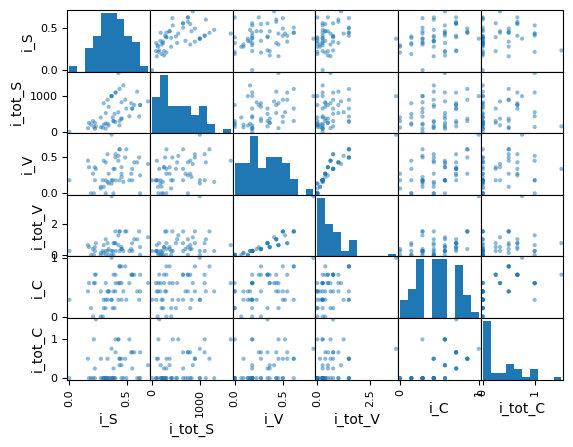

In [ ]:
from pandas.plotting import scatter_matrix

# df_features.plot.scatter('i_S', 'i_tot_S', alpha=0.2)
# df_features.plot.scatter('i_C', 'i_tot_C', alpha=0.2)
# df_features.plot.scatter('i_V', 'i_tot_V', alpha=0.2)
# df_features.plot.scatter('i_e8', 'i_e3', alpha=0.2)
# df_features.plot.scatter('i_e7', 'i_e6', alpha=0.2)
# df_features.plot.scatter('i_e9', 'i_e8', alpha=0.2)

#    casa  i_e_1, i_e_3, i_e_6
#  lavoro  i_e_2, i_e_4, i_e_7


scatter_matrix(df_features[['i_e1', 'i_e3', 'i_e6', 'i_e2', 'i_e4', 'i_e7']], diagonal='kde')
scatter_matrix(df_features[['i_e1', 'i_e3', 'i_e6', 'i_e2', 'i_e4', 'i_e7']], diagonal='hist')

scatter_matrix(df_features[['i_e8', 'i_e9', 'i_e10', 'i_e11']], diagonal='kde')
scatter_matrix(df_features[['i_e8', 'i_e9', 'i_e10', 'i_e11']], diagonal='hist')

scatter_matrix(df_features[['i_S', 'i_tot_S', 'i_V', 'i_tot_V', 'i_C', 'i_tot_C']], diagonal='kde')
scatter_matrix(df_features[['i_S', 'i_tot_S', 'i_V', 'i_tot_V', 'i_C', 'i_tot_C']], diagonal='hist')

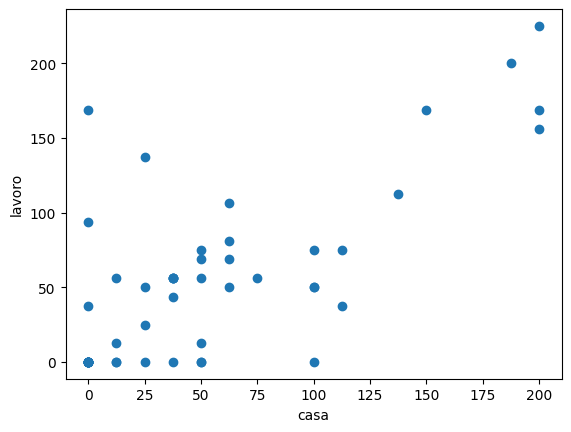

In [ ]:
from matplotlib import pyplot

fig, ax = pyplot.subplots()
pyplot.xlabel('casa')
pyplot.ylabel('lavoro')
ax.scatter(df_features['i_e8'], df_features['i_e9'])

In [ ]:
print(model.hasSummary)
summary = model.summary
print(summary.k)
print(summary.clusterSizes)

summary.cluster.show(52)

True
3
[28, 6, 18]
+----------+
|prediction|
+----------+
|         2|
|         0|
|         2|
|         0|
|         0|
|         0|
|         1|
|         0|
|         0|
|         1|
|         0|
|         2|
|         0|
|         0|
|         0|
|         0|
|         2|
|         2|
|         2|
|         0|
|         2|
|         2|
|         2|
|         2|
|         0|
|         0|
|         2|
|         2|
|         2|
|         0|
|         0|
|         2|
|         1|
|         0|
|         2|
|         0|
|         1|
|         2|
|         0|
|         0|
|         0|
|         0|
|         0|
|         0|
|         0|
|         0|
|         1|
|         2|
|         1|
|         2|
|         0|
|         0|
+----------+

None
